<a href="https://colab.research.google.com/github/psahai10/AIFellowship/blob/main/Uplift_modelling_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/Vigneshsab/Uplift-Modelling-to-maximize-revenue-through-marketing-campaigns

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# load in packages
from itertools import combinations
#from test_results import valid_results, test_results, score

import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:

df = pd.read_csv('/content/drive/My Drive/marketing_campaign.csv', delimiter=';')

In [4]:
def explore_data(df):
    bold = '\033[1m'
    end = '\033[0m' 
    print(str())
    print(bold+'DataFrame Head:'+end)
    display(df.head())
    print(bold+'DataFrame Shape:'+end)
    display(df.shape)
    print(bold+'DataFrame Data Types:'+end)
    display(df.dtypes)
    print(bold+'DataFrame Null Values:'+end)
    display(np.sum(df.isnull()))
    print(bold+'DataFrame Summary Stats:'+end)
    display(df.describe())
    print("-------------------------------")

In [5]:
explore_data(df)


DataFrame Head:


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


DataFrame Shape:


(2240, 29)

DataFrame Data Types:


ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

DataFrame Null Values:


ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

DataFrame Summary Stats:


,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


-------------------------------


In [6]:
# Missing data
def missing_rep(df):
    missing = df.isna().sum()
    missing = missing[missing > 0]
    missing_proportion = missing / df.shape[0]
    missing_3perc = missing_proportion > 0.03

    return pd.DataFrame({"Missings" : missing, 
           "Proportion of Missings" : missing_proportion,
           "Higher than 3%" : missing_3perc})

In [7]:
missing_rep(df)

,Missings,Proportion of Missings,Higher than 3%
Income,24,0.010714,False


In [8]:
# Transforms date format in days
from datetime import datetime
def days_since(dates_series, date_format):
    n = len(dates_series)
    result = [0] * n

    for i in range(n):
        result[i] = (datetime.today() - datetime.strptime(dates_series[i], date_format)).days
    
    return result

df["Days_Customer"] = days_since(list(df.Dt_Customer), "%Y-%m-%d")
df = df.drop(columns="Dt_Customer")
df["Days_Customer"].head()

0    3110
1    2560
2    2759
3    2586
4    2608
Name: Days_Customer, dtype: int64

In [9]:
# Describes numerical attributes
categorical_features = ["Education", "Marital_Status", 
      "Kidhome", "Teenhome", "AcceptedCmp1", 
      "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4",
      "AcceptedCmp5", "Complain"]
numerical_features = list(df.columns)
numerical_features = list(filter(lambda x: x not in categorical_features, numerical_features))

In [10]:
numerical_features.remove("ID") # Removing ID column
df[numerical_features].describe() # Describing only Numerical Variables

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,Response,Days_Customer
count,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000,2240.000000
mean,1968.805804,52247.251354,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,3.0,11.0,0.149107,2800.582143
std,11.984069,25173.076661,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.0,0.0,0.356274,202.122512
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,2447.000000
25%,1959.000000,35303.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,3.0,11.0,0.000000,2627.750000
50%,1970.000000,51381.500000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,3.0,11.0,0.000000,2802.500000
75%,1977.000000,68522.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,3.0,11.0,0.000000,2976.000000
max,1996.000000,666666.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,3.0,11.0,1.000000,3146.000000


In [11]:
# Drops constant variables
std = df[numerical_features].describe().iloc[2,:]
std

Year_Birth                11.984069
Income                 25173.076661
Recency                   28.962453
MntWines                 336.597393
MntFruits                 39.773434
MntMeatProducts          225.715373
MntFishProducts           54.628979
MntSweetProducts          41.280498
MntGoldProds              52.167439
NumDealsPurchases          1.932238
NumWebPurchases            2.778714
NumCatalogPurchases        2.923101
NumStorePurchases          3.250958
NumWebVisitsMonth          2.426645
Z_CostContact              0.000000
Z_Revenue                  0.000000
Response                   0.356274
Days_Customer            202.122512
Name: std, dtype: float64

In [12]:
const_lab = [std[std<0.05].index[0], std[std<0.05].index[1]]
std[std<0.05]

Z_CostContact    0.0
Z_Revenue        0.0
Name: std, dtype: float64

In [13]:
df.drop(labels=const_lab, axis=1, inplace=True)
numerical_features = list(filter(lambda x: x not in const_lab, numerical_features))

In [14]:
# Removes inconsistant age
df[(2020 - df["Year_Birth"])>90]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_Customer
192,7829,1900,2n Cycle,Divorced,36640.0,1,0,99,15,6,8,7,4,25,1,2,1,2,5,0,0,0,0,0,1,0,2723
239,11004,1893,2n Cycle,Single,60182.0,0,1,23,8,0,5,7,0,2,1,1,0,2,4,0,0,0,0,0,0,0,2490
339,1150,1899,PhD,Together,83532.0,0,0,36,755,144,562,104,64,224,1,4,6,4,1,0,0,1,0,0,0,0,2723


In [15]:
#Removes inconsistent age
df = df[(2020 - df["Year_Birth"])<=90]

In [16]:
#Drops rows with less missing income (about 1% of the data)
df = df[~df['Income'].isna()]
df.shape

(2213, 27)

In [17]:
# Correlation matrix
# The function to "zoom" in the correlation matrix.
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]

def corr_matrix(df):
    # Compute the correlation matrix
    corr = df.corr()
    cmap = sns.diverging_palette(5, 250, as_cmap=True)
    
    vis = corr.style.background_gradient(cmap, axis=1)\
            .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
            .set_caption("Hover to magify")\
            .set_precision(2)\
            .set_table_styles(magnify())

    return vis

In [18]:
import seaborn as sns
feat_n_ = numerical_features.copy()
numerical_features.remove("Response") # Removing the Targer variable from the list of numerical features to be analyzed by correlation.
corr_matrix(df[numerical_features])

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Days_Customer
Year_Birth,1.00,-0.16,-0.02,-0.16,-0.01,-0.03,-0.04,-0.02,-0.06,-0.07,-0.16,-0.13,-0.14,0.12,0.01
Income,-0.16,1.00,-0.00,0.58,0.43,0.58,0.44,0.44,0.33,-0.08,0.39,0.59,0.53,-0.55,-0.02
Recency,-0.02,-0.00,1.00,0.02,-0.01,0.02,0.00,0.03,0.02,0.00,-0.01,0.02,-0.00,-0.02,0.03
MntWines,-0.16,0.58,0.02,1.00,0.39,0.57,0.40,0.39,0.39,0.01,0.55,0.63,0.64,-0.32,0.17
MntFruits,-0.01,0.43,-0.01,0.39,1.00,0.55,0.59,0.57,0.39,-0.13,0.30,0.49,0.46,-0.42,0.07
MntMeatProducts,-0.03,0.58,0.02,0.57,0.55,1.00,0.57,0.53,0.36,-0.12,0.31,0.73,0.49,-0.54,0.09
MntFishProducts,-0.04,0.44,0.00,0.40,0.59,0.57,1.00,0.58,0.43,-0.14,0.30,0.53,0.46,-0.45,0.08
MntSweetProducts,-0.02,0.44,0.03,0.39,0.57,0.53,0.58,1.00,0.36,-0.12,0.33,0.49,0.46,-0.42,0.08
MntGoldProds,-0.06,0.33,0.02,0.39,0.39,0.36,0.43,0.36,1.00,0.05,0.41,0.44,0.39,-0.25,0.16
NumDealsPurchases,-0.07,-0.08,0.00,0.01,-0.13,-0.12,-0.14,-0.12,0.05,1.00,0.24,-0.01,0.07,0.35,0.22


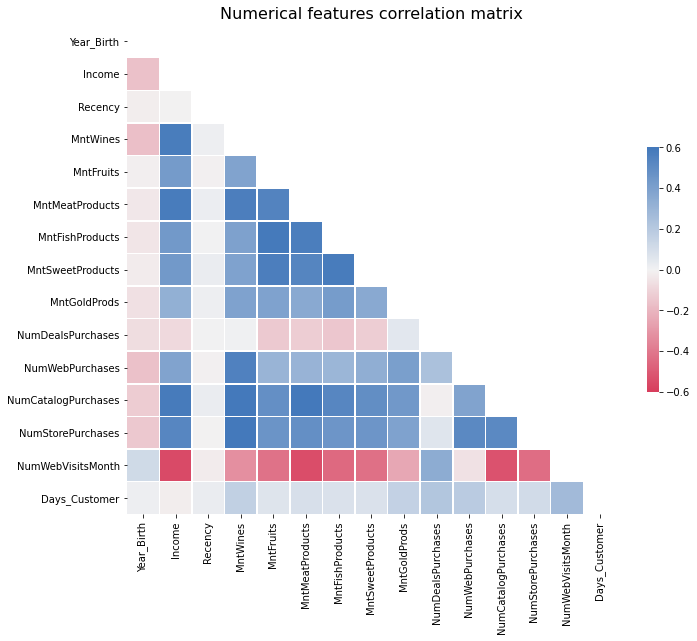

In [19]:
corr = df[numerical_features].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

plt.figure(figsize=(11,9))

cmap = sns.diverging_palette(5, 250, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.6, vmin=-.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Numerical features correlation matrix", fontsize=16)
plt.show()

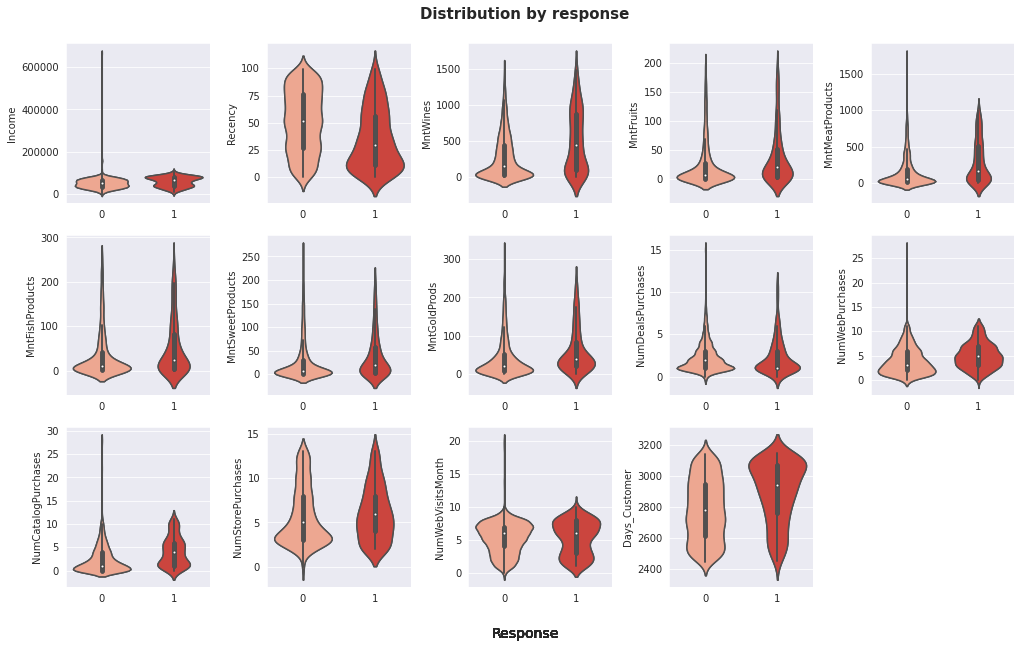

In [20]:
# Distribution according to response
def num_feat_plot(df, feat_nlist, target, feat_clist = None):
    
    sns.set_style("darkgrid")    
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.4)
    i=1
    
    if(target in feat_nlist):
        feat_nl = feat_nlist.copy()
        feat_nl.remove(target)

    
    for feat in feat_nl:
        sns.violinplot(data = df, y = feat, x = target)
        ax=sns.violinplot(data = df, y = feat, x = target, palette="Reds")
        ax.set_xlabel("", size = 10)
        
        if i<15:
            plt.subplot(3, 5, i)
            i+=1
        
        fig.suptitle('Distribution by response', ha='center',
                     va='center', fontsize=15, y=0.92, fontweight='bold')
        fig.text(0.5, 0.06, 'Response', ha='center', va='center', fontsize=14)
        fig.set_figheight(10)
        fig.set_figwidth(17)

    return

num_feat_plot(df, feat_n_, "Response")

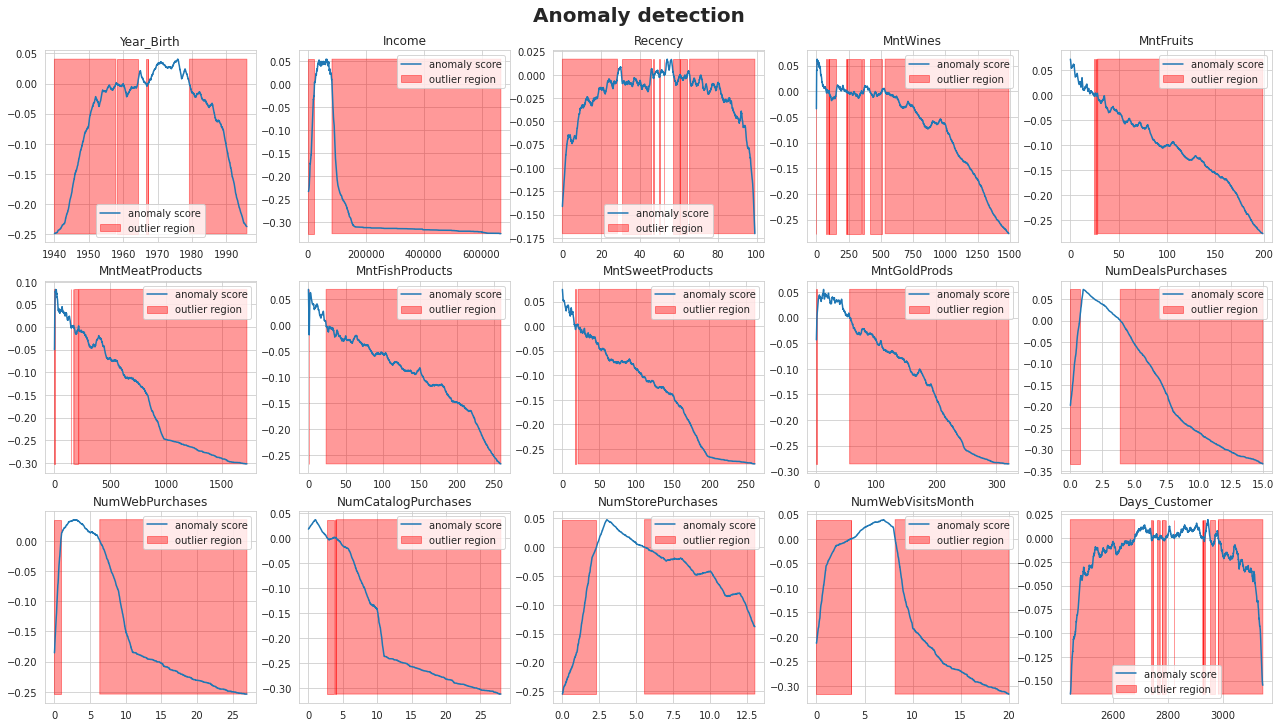

In [21]:
# Outlier detection
from sklearn.ensemble import IsolationForest

def anom_plot(df, num_feat_list, l, c):
    sns.set_style("whitegrid") 
    fig, axs = plt.subplots(l, c, figsize=(22, 12), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    for i, column in enumerate(num_feat_list):
        isolation_forest = IsolationForest(n_estimators=500, contamination="auto")
        isolation_forest.fit(df[column].values.reshape(-1,1))

        xx = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
        anomaly_score = isolation_forest.decision_function(xx)
        outlier = isolation_forest.predict(xx)
    
        axs[i].plot(xx, anomaly_score, label='anomaly score')
        axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
        axs[i].legend()
        axs[i].set_title(column)
        
    fig.suptitle('Anomaly detection', ha='center',
                     va='center', fontsize=20, y=0.92, fontweight='bold')
        
    return
    
anom_plot(df, numerical_features, 3, 5)

In [22]:
def filter_by_iqr(series_, k=1.5, return_thresholds=False):
    q25, q75 = np.percentile(series_, 25), np.percentile(series_, 75)
    iqr = q75-q25
    
    cutoff = iqr*k
    lower_bound, upper_bound = q25-cutoff, q75+cutoff
    
    if return_thresholds:
        return lower_bound, upper_bound
    else:
        return [True if i < lower_bound or i > upper_bound else False for i in series_]

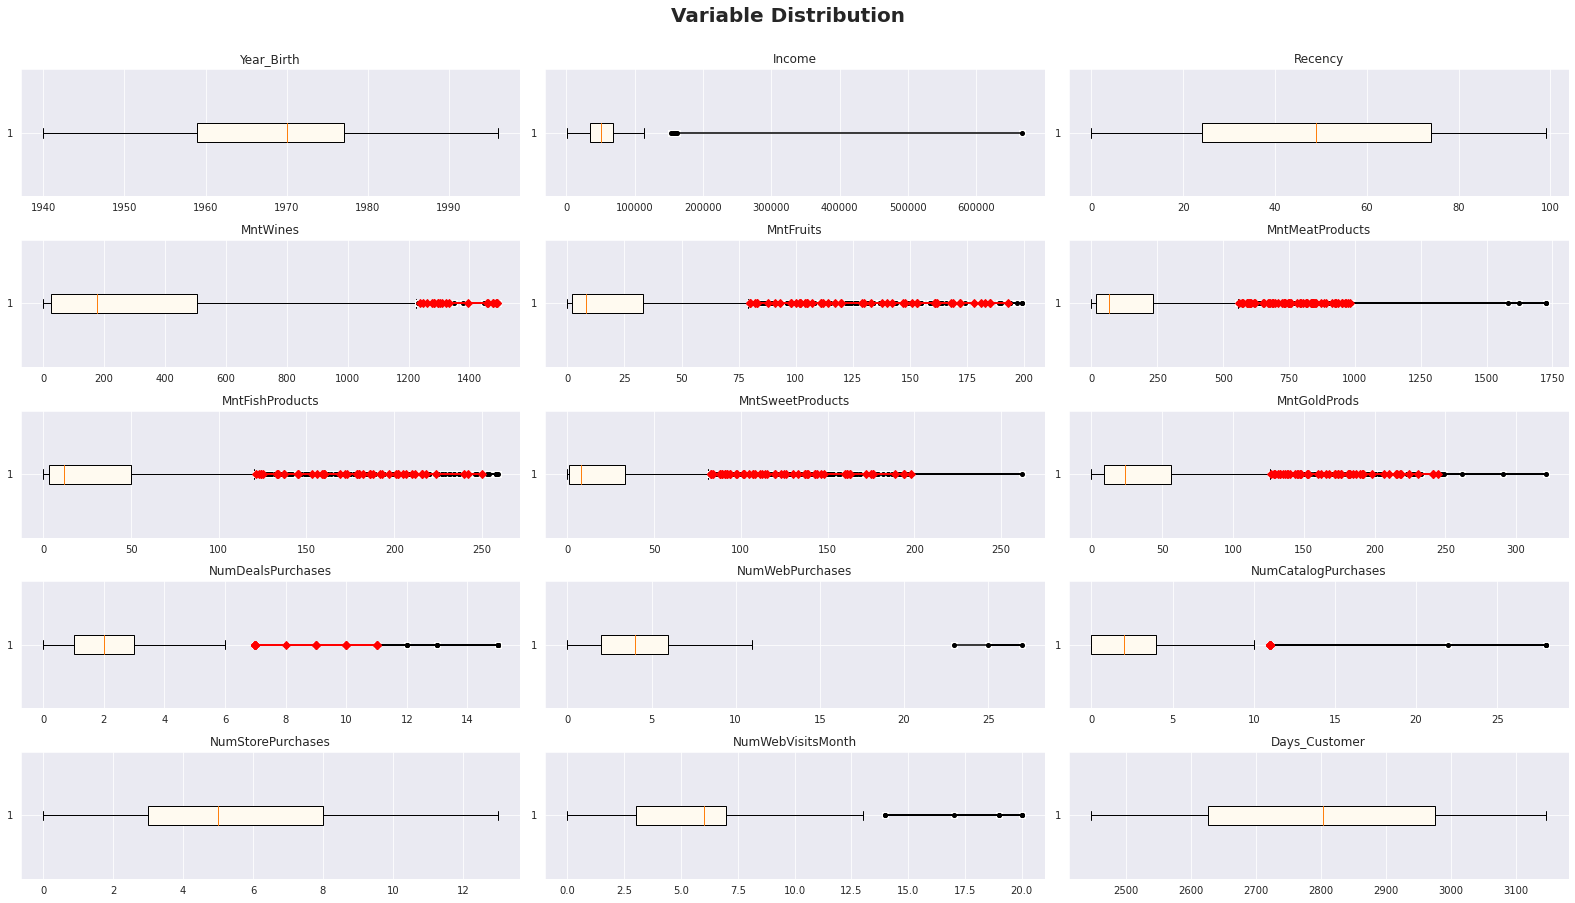

In [23]:
from sklearn.preprocessing import KBinsDiscretizer

def bivariate_outlier_id_plot(df, list_num_features, target, n_bins=20):
    sns.set_style("darkgrid") 
    fig = plt.figure(figsize=(22, 12))
    color = "floralwhite"
    i=1
    for feature in list_num_features:
        if feature == "Income":
            ser = df[feature].copy()
            ser.dropna(inplace=True)
        else:
            ser = df[feature]
          
        # box plots
        thresholds = filter_by_iqr(ser, 1.5, True)
        outliers = df[[feature, target]][df[feature]>thresholds[1]]

        ax = fig.add_subplot(5, 3, i)

        box = ax.boxplot(ser, flierprops=dict(markerfacecolor='r', marker='s'), 
                         vert=False, patch_artist=True, sym="w")                                                                  
        ax.plot(outliers.iloc[:, 0][outliers.iloc[:, 1]==0], np.ones(sum(outliers.iloc[:, 1]==0)), color="black", marker = "o", markersize=4)
        ax.plot(outliers.iloc[:, 0][outliers.iloc[:, 1]==1], np.ones(sum(outliers.iloc[:, 1]==1)), color="red", marker = "D", markersize=6)
        ax.set_title(feature)
        box['boxes'][0].set_facecolor(color)

        i+=1
        
    fig.suptitle('Variable Distribution',  ha='center',
                     va='center', fontsize=20, y=1.03, fontweight='bold')

    plt.tight_layout()
    plt.show()

bivariate_outlier_id_plot(df, numerical_features, "Response", n_bins=20)

In [24]:
seeds = [4, 56, 92, 105, 400]

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    df["Response"],
                                                    test_size=0.3,
                                                    random_state=seeds[0])

In [26]:
# Simple function to check if the matrix is positive definite 
#(for example, it will return False if the matrix contains NaN).
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False 

# The function to calculate the Mahalanobis Distance. Returns a list of distances.
def MahalanobisDist(data):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(data.shape[0]):
                vars_mean.append(list(data.mean(axis=0)))
            diff = data - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
            return md
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")
        
def MD_detectOutliers(data, extreme=False):
    MD = MahalanobisDist(data)

    std = np.std(MD)
    k = 3. * std if extreme else 2. * std
    m = np.mean(MD)
    up_t = m + k
    low_t = m - k
    outliers = []
    for i in range(len(MD)):
        if (MD[i] >= up_t) or (MD[i] <= low_t):
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [27]:
data_aux = X_train[feat_n_]
outliers_i = MD_detectOutliers(np.array(data_aux))
len(outliers_i)

36

In [28]:
outliers = pd.DataFrame()
for i in outliers_i:
    outliers = outliers.append(data_aux.iloc[i,:])
    
outliers.head()

,Days_Customer,Income,MntFishProducts,MntFruits,MntGoldProds,MntMeatProducts,MntSweetProducts,MntWines,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Response,Year_Birth
914,3020.0,95529.0,250.0,29.0,24.0,890.0,27.0,770.0,3.0,1.0,7.0,7.0,3.0,29.0,1.0,1994.0
1743,2976.0,70321.0,82.0,23.0,191.0,751.0,26.0,303.0,5.0,1.0,13.0,6.0,4.0,6.0,1.0,1947.0
1946,3051.0,63211.0,205.0,193.0,145.0,459.0,26.0,145.0,8.0,2.0,7.0,3.0,2.0,3.0,1.0,1982.0
203,3051.0,102160.0,76.0,29.0,58.0,138.0,176.0,763.0,9.0,0.0,10.0,7.0,4.0,54.0,1.0,1977.0
855,2901.0,60474.0,234.0,199.0,170.0,303.0,9.0,265.0,2.0,7.0,12.0,10.0,7.0,25.0,0.0,1979.0


In [29]:
# Drop Outliers
X_train = X_train[~X_train.index.isin(outliers.index)]
y_train = y_train[~y_train.index.isin(outliers.index)]

In [30]:
# Percentage of Monetary Units spent on gold products out of the total spent
X_train.shape[0]

1513

In [31]:
cpgn=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Income','Recency','NumWebVisitsMonth']

### From these graphs below, we can see that when given a discount on the products, customers have purchased more through web than catalogs and stores. Now we will create a binary column to assing people who have purchased goods through either stores, catalogs or web as '1' and others as '0'.
1. First graph: Given a discount, has the customer bought something? <code> df['NumDealsPurchases']!=0) </code> And did this purchase happend in Catalog? <code> df['NumCatalogPurchases']!=0) </code> 
2. Second graph: Given a discount, has the customer bought something? <code> df['NumDealsPurchases']!=0) </code> And did this purchase happend In-Store? <code> df['NumStorePurchases']!=0) </code> 
3. Second graph: Given a discount, has the customer bought something? <code> df['NumDealsPurchases']!=0) </code> And did this purchase happend in the Web? <code> df['NumWebPurchases']!=0) </code> 

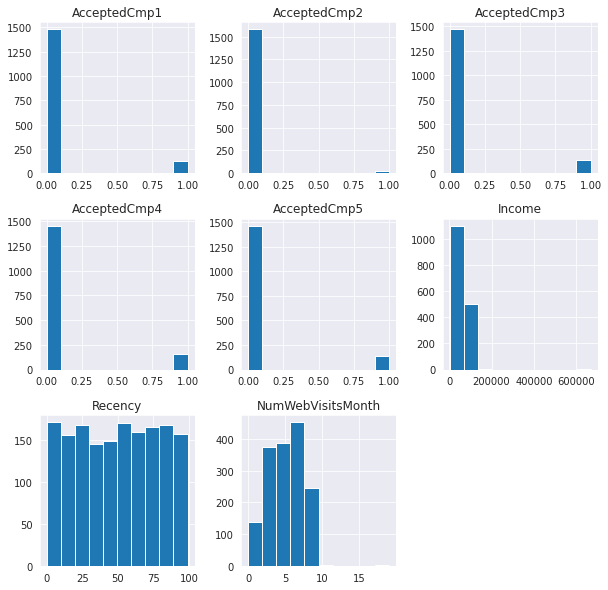

In [32]:
df[(df['NumDealsPurchases']!=0) & (df['NumCatalogPurchases']!=0)][cpgn].hist(figsize=(10,10));

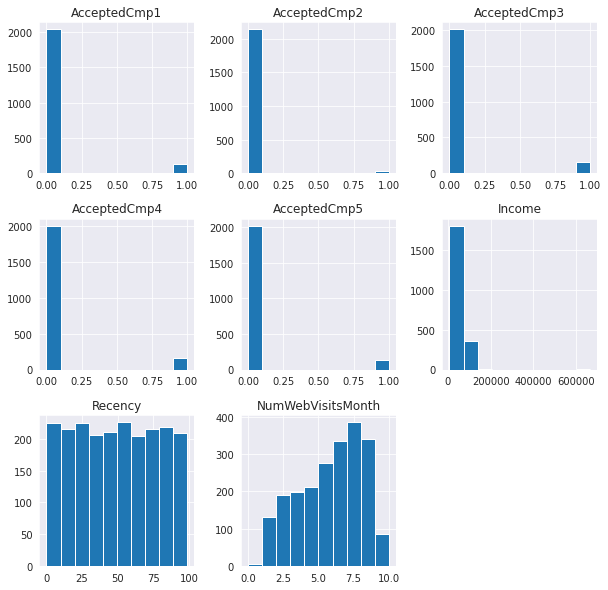

In [33]:
df[(df['NumDealsPurchases']!=0) & (df['NumStorePurchases']!=0)][cpgn].hist(figsize=(10,10));

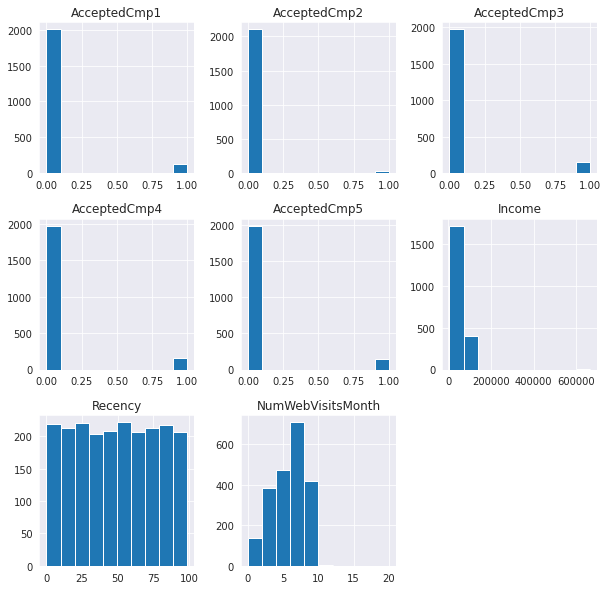

In [34]:
df[(df['NumDealsPurchases']!=0) & (df['NumWebPurchases']!=0)][cpgn].hist(figsize=(10,10));

### Given a discount, has a purchased been done. 
### In other words: <code> if NumDealsPurchases > 0, then discount == 1; else 0 </code>

In [35]:

# Given a discount, has a purchased been done. In other words, if NumDealsPurchases > 0, then discount == 1; else 0
discount=[]
for i in range(len(df)):
    if ((df['NumDealsPurchases'].iloc[i]==0)):
        discount.append(0)
    else:
        discount.append(1)

In [36]:
df['Discount']=discount
#deleting unnecessary columns
df= df.drop(columns=['NumDealsPurchases','NumCatalogPurchases','NumStorePurchases','NumWebPurchases','Year_Birth','Education','Kidhome','Teenhome','Marital_Status','Days_Customer'])


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2213 entries, 0 to 2239
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 2213 non-null   int64  
 1   Income             2213 non-null   float64
 2   Recency            2213 non-null   int64  
 3   MntWines           2213 non-null   int64  
 4   MntFruits          2213 non-null   int64  
 5   MntMeatProducts    2213 non-null   int64  
 6   MntFishProducts    2213 non-null   int64  
 7   MntSweetProducts   2213 non-null   int64  
 8   MntGoldProds       2213 non-null   int64  
 9   NumWebVisitsMonth  2213 non-null   int64  
 10  AcceptedCmp3       2213 non-null   int64  
 11  AcceptedCmp4       2213 non-null   int64  
 12  AcceptedCmp5       2213 non-null   int64  
 13  AcceptedCmp1       2213 non-null   int64  
 14  AcceptedCmp2       2213 non-null   int64  
 15  Complain           2213 non-null   int64  
 16  Response           2213 

In [38]:
# values, counts = np.unique(discount, return_counts=True)
# values
# counts

array([  44, 2169])

In [39]:
# train,test=train_test_split(df,test_size=0.2, random_state=42)

# Model 1: Baseline
### Baseline model: Promotion is sent to everyone. No selection.

In [40]:
# testing baseline model, where we send promotions to everyone
def promotion_strategy(df):
    '''
    Ex:
    INPUT: df
    AcceptedCmp1->AcceptedCmp2->AcceptedCmp3->AcceptedCmp4->AcceptedCmp5->Income->Recency->NumWebVisitsMonth
    OUTPUT: promotion
    array([1, 1, 0])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    promotion = []
    num_test_points = test.shape[0]
    for i in range(num_test_points):
        promotion.append(1)
    promotion = np.array(promotion)
    return promotion

In [41]:
def score(df, promo_pred_col = 'Discount'):
    n_treat       = df.loc[df[promo_pred_col] == 1,:].shape[0] # Size of treatment group (n)
    n_control     = df.loc[df[promo_pred_col] == 0,:].shape[0] # Size of control group (n)
    n_treat_purch = df.loc[df[promo_pred_col] == 1, 'Response'].sum() # if a customer made a purchase during a promo, what was his reponse (summed up over the whole group)
    n_ctrl_purch  = df.loc[df[promo_pred_col] == 0, 'Response'].sum() # if a customer DID NOT make a purchase during a promo, what was his reponse (summed up over the whole group)
    nir = 11*n_treat_purch - 3 * n_treat + 11*n_ctrl_purch # nir = 11*% of customer that made a purchase and responded to an AD
                                                          # - 3* size of the treatment group + 11* Customers that DID NOT make a purchase but got an AD
    return (nir)

def test_results(promotion_strategy, test):
    test_data = test
    df = test_data[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Income','Recency','NumWebVisitsMonth']]
    promos = promotion_strategy(df)
    score_df = test_data.iloc[np.where(promos == 1)]    
    nir = score(score_df)
    print()
    print('Your Revenue generated with this strategy is {:0.2f}.'.format(nir))
    print()
    return nir

In [42]:
test_results(promotion_strategy, test)


Your Revenue generated with this strategy is -422.00.



-422

In [43]:
# generate labels
# only those who made a purchase after receiving a promotion will be assigned a label of 1, 
# while the other individuals will be given a label of 0

response_by_cust = []
for index, row in train.iterrows():
    if (row['Response'] == 1) and (row['Discount']==1):
        response_by_cust.append(1.0)
    else:
        response_by_cust.append(0.0)
train['response_by_cust'] = response_by_cust

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [44]:
train['response_by_cust'].value_counts()

0.0    1530
1.0     240
Name: response_by_cust, dtype: int64

In [45]:
train, valid = sk.model_selection.train_test_split(train, test_size=0.2,random_state=42)

In [46]:
# generate features and labels
Y_train = train['response_by_cust']
X_train = train[cpgn]

Y_valid = valid['response_by_cust']
X_valid = valid[cpgn]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


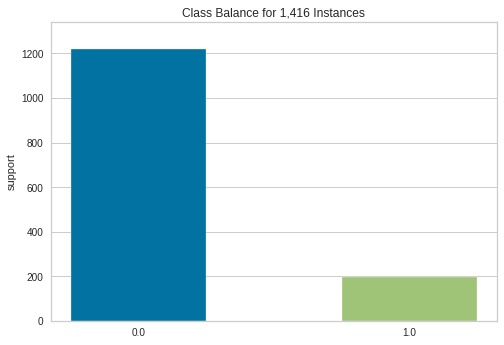

In [47]:
from yellowbrick.target import class_balance
class_balance(Y_train);


In [48]:
# up sample only the train dataset with SMOTE
sm = SMOTE(random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=cpgn)
Y_train_upsamp = pd.Series(Y_train_upsamp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [49]:
# Train an xgboost model
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 8,\
                          min_child_weight = 4,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.943306	validation_1-auc:0.76074
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.950903	validation_1-auc:0.766019
[2]	validation_0-auc:0.952185	validation_1-auc:0.759421
[3]	validation_0-auc:0.956034	validation_1-auc:0.759421
[4]	validation_0-auc:0.956547	validation_1-auc:0.76382
[5]	validation_0-auc:0.956515	validation_1-auc:0.768035
[6]	validation_0-auc:0.957927	validation_1-auc:0.773754
[7]	validation_0-auc:0.959112	validation_1-auc:0.771628
[8]	validation_0-auc:0.960561	validation_1-auc:0.776796
[9]	validation_0-auc:0.961352	validation_1-auc:0.777529
[10]	validation_0-auc:0.963266	validation_1-auc:0.774084
[11]	validation_0-auc:0.964437	validation_1-auc:0.774523
[12]	validation_0-auc:0.965928	validation_1-auc:0.775623
[13]	validation_0-auc:0.966917	validation_1-auc:0.778556
[14]	validation_0-auc:0.968043	validation_1-auc:0.780169


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=4, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

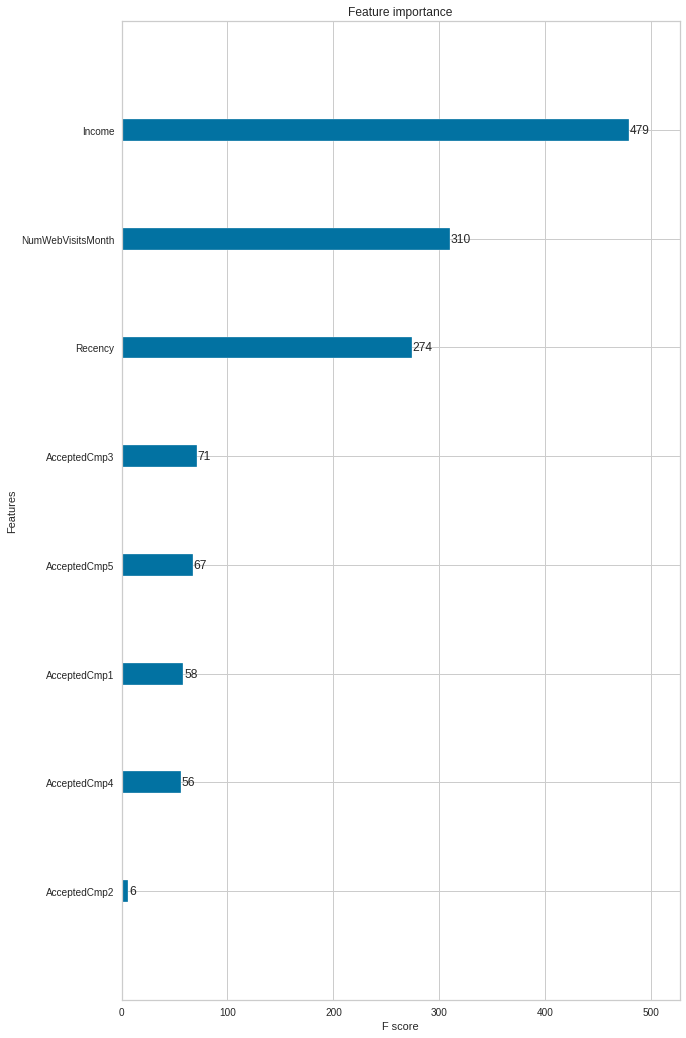

In [50]:

# check which features are important

from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);

In [51]:

# confusion matrix
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix
cm(Y_valid, valid_pred)

array([[275,  35],
       [ 34,  10]])

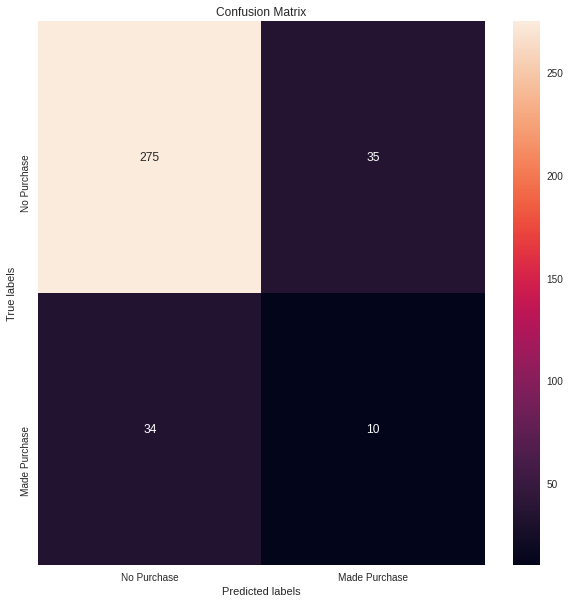

In [52]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [53]:
def promotion_strategy(df):
    '''
    Ex:
    INPUT: df
    AcceptedCmp1->AcceptedCmp2->AcceptedCmp3->AcceptedCmp4->AcceptedCmp5->Income->Recency->NumWebVisitsMonth
    OUTPUT: promotion
    
    array([1, 1, 0])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    preds = model.predict(test, ntree_limit=model.best_ntree_limit)
    
    promotion = []
    for pred in preds:
        if pred == 1:
            promotion.append(1)
        else:
            promotion.append(0)
    promotion = np.array(promotion)
    return promotion

In [54]:
# added this function to test our irr and nlr on the validation set
def valid_results(promotion_strategy, valid_data):
    df = valid_data[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Income','Recency','NumWebVisitsMonth']]
    promos = promotion_strategy(df)
    score_df = valid_data.iloc[np.where(promos == 1)]    
    nir = score(score_df)
    print()
    print('Your Revenue generated with this strategy is {:0.2f}.'.format(nir))
    print()
    return nir

In [55]:
# test irr and nlr on our validation set
valid_results(promotion_strategy, valid)


Your Revenue generated with this strategy is 15.00.



15

In [56]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy, test)


Your Revenue generated with this strategy is 123.00.



123

# Model 2: Using two models approach

In this approach, we will train two models. One model will be trained on the treatment group (those who received the promotion) and we will refer to this model as the treatment model. Another model will be trained on the control group (those who did not received the promotion), and we will refer to this as the control model. The target of both models will be whether the individual made the purchase or not. The treatment model will predict the probability that individual will make a purchase if he or she received the promotion, while the control model will predict the probability that individual will make a purchase if he or she did not receive the promotion. Ideally the difference in the probabilities, which we will call the lift:

$$ Lift = P(purchase | treatment) - P(purchase | control) $$

will tell us the probability that sending a promotion to an individual will increase his or her willingness to make a purhcase vs not sending a promotion. We can then send promotions to individuals with lift values higher than a pre-defined cutoff percentile. For example, we can send promotions to individuals in the top 3 deciles.

This model performed quite well than the third model, but still predicted that the company would face a little loss if they followed this strategy. 

In [57]:
train, test = sk.model_selection.train_test_split(df, test_size=0.2,random_state=42)

In [58]:
train, valid = sk.model_selection.train_test_split(train, test_size=0.2,random_state=42)

In [59]:
cpgn=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Income','Recency','NumWebVisitsMonth']

# Generate validation data
# one for control group, another for treatment group
valid_control = valid[valid['Discount']==0]
Y_valid_control = valid_control['Response']
X_valid_control = valid_control[cpgn]

valid_exper = valid[valid['Discount']==1]
Y_valid_exper = valid_exper['Response']
X_valid_exper = valid_exper[cpgn]

In [60]:
# generate training data
train_control = train[train['Discount']==0]
Y_train_control = train_control['Response']
X_train_control = train_control[cpgn]

train_exper = train[train['Discount']==1]
Y_train_exper = train_exper['Response']
X_train_exper = train_exper[cpgn]

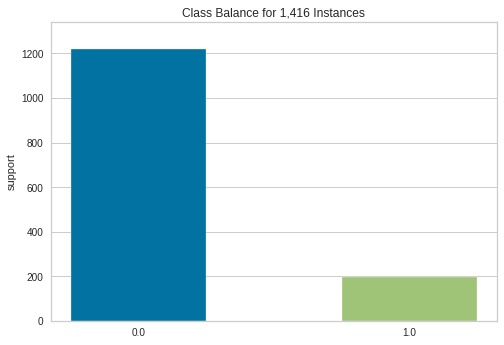

In [61]:
from yellowbrick.target import class_balance
class_balance(Y_train);


In [62]:
# up-sample training data with SMOTE
sm = SMOTE(random_state=42)

# up-sample control group
X_train_control_upsamp, Y_train_control_upsamp = sm.fit_sample(X_train_control, Y_train_control)
X_train_control_upsamp = pd.DataFrame(X_train_control_upsamp, columns=cpgn)
Y_train_control_upsamp = pd.Series(Y_train_control_upsamp)

# up-sample treatment group
X_train_exper_upsamp, Y_train_exper_upsamp = sm.fit_sample(X_train_exper, Y_train_exper)    
X_train_exper_upsamp = pd.DataFrame(X_train_exper_upsamp, columns=cpgn)
Y_train_exper_upsamp = pd.Series(Y_train_exper_upsamp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [63]:

# train control model
eval_set = [(X_train_control_upsamp, Y_train_control_upsamp), (X_valid_control, Y_valid_control)]
model_control = xgb.XGBClassifier(learning_rate = 0.1,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'binary:logistic',\
                                  seed = 42,\
                                  gamma = 1,\
                                  #colsample_bytree = 0.1,\
                                  silent = True)
model_control.fit(X_train_control_upsamp, Y_train_control_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.5	validation_1-auc:0.5
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.5	validation_1-auc:0.5
[2]	validation_0-auc:0.5	validation_1-auc:0.5
[3]	validation_0-auc:0.5	validation_1-auc:0.5
[4]	validation_0-auc:0.5	validation_1-auc:0.5
[5]	validation_0-auc:0.5	validation_1-auc:0.5
[6]	validation_0-auc:0.5	validation_1-auc:0.5
[7]	validation_0-auc:0.5	validation_1-auc:0.5
[8]	validation_0-auc:0.5	validation_1-auc:0.5
[9]	validation_0-auc:0.5	validation_1-auc:0.5
[10]	validation_0-auc:0.5	validation_1-auc:0.5
[11]	validation_0-auc:0.5	validation_1-auc:0.5
[12]	validation_0-auc:0.5	validation_1-auc:0.5
[13]	validation_0-auc:0.5	validation_1-auc:0.5
[14]	validation_0-auc:0.5	validation_1-auc:0.5
[15]	validation_0-auc:0.5	validation_1-auc:0.5
[16]	validation_0-auc:0.5	validation_1-auc:0.5
[17]	validation_0-auc:0.5	validation_1-auc:0.5
[18]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

In [64]:
# train treatment model
eval_set = [(X_train_exper_upsamp, Y_train_exper_upsamp), (X_valid_exper, Y_valid_exper)]
model_exper = xgb.XGBClassifier(learning_rate = 0.1,\
                                max_depth = 7,\
                                min_child_weight = 5,\
                                objective = 'binary:logistic',\
                                seed = 42,\
                                gamma = 1,\
                                #colsample_bytree = 0.1,\
                                silent = True)
model_exper.fit(X_train_exper_upsamp, Y_train_exper_upsamp, eval_set=eval_set,\
                eval_metric="auc", verbose=True, early_stopping_rounds=30)


[0]	validation_0-auc:0.930709	validation_1-auc:0.76899
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.937307	validation_1-auc:0.789792
[2]	validation_0-auc:0.940218	validation_1-auc:0.778843
[3]	validation_0-auc:0.942458	validation_1-auc:0.773331
[4]	validation_0-auc:0.941759	validation_1-auc:0.768952
[5]	validation_0-auc:0.943473	validation_1-auc:0.780957
[6]	validation_0-auc:0.946353	validation_1-auc:0.784166
[7]	validation_0-auc:0.948022	validation_1-auc:0.787942
[8]	validation_0-auc:0.949861	validation_1-auc:0.784355
[9]	validation_0-auc:0.949644	validation_1-auc:0.784657
[10]	validation_0-auc:0.953515	validation_1-auc:0.784129
[11]	validation_0-auc:0.954449	validation_1-auc:0.784921
[12]	validation_0-auc:0.956001	validation_1-auc:0.78613
[13]	validation_0-auc:0.957176	validation_1-auc:0.789829
[14]	validation_0-auc:0.958475	validation_1-auc:0.79553
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

In [65]:
# make predictions on the validation data sets for both models
control_valid_pred = model_control.predict(X_valid_control, ntree_limit=model_control.best_ntree_limit)
exper_valid_pred = model_exper.predict(X_valid_exper, ntree_limit=model_exper.best_ntree_limit)

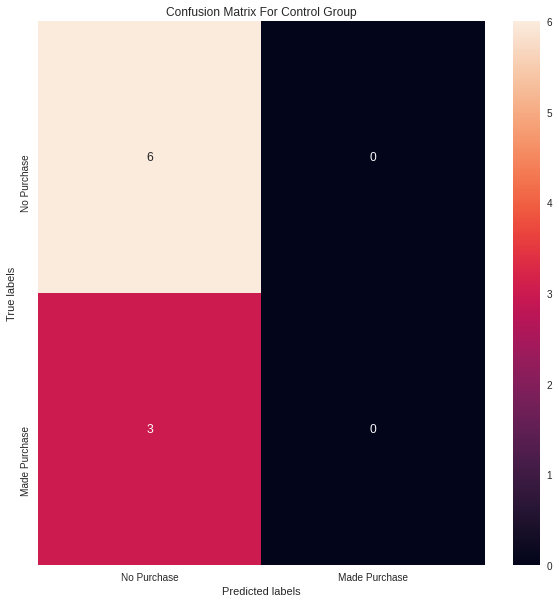

In [66]:

# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid_control, control_valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix For Control Group'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

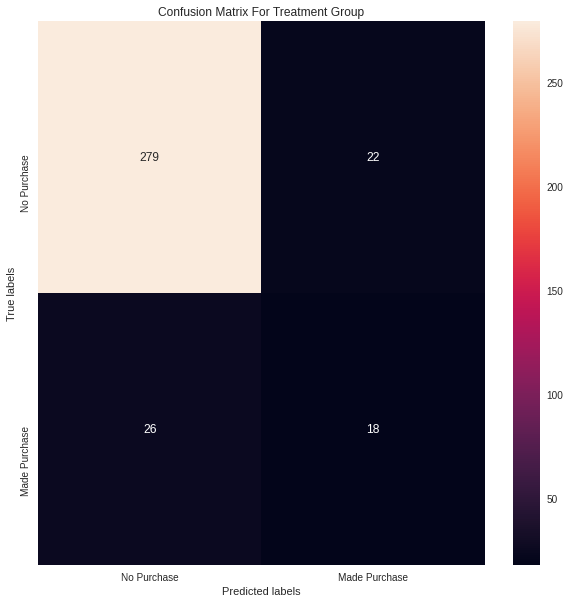

In [67]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid_exper, exper_valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix For Treatment Group'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [68]:
def promotion_strategy(df):
    ''' 
    Ex:
    INPUT: df
    AcceptedCmp1->AcceptedCmp2->AcceptedCmp3->AcceptedCmp4->AcceptedCmp5->Income->Recency->NumWebVisitsMonth
    OUTPUT: promotion
    array([1, 1, 0])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    pred_probs_control = model_control.predict_proba(test, ntree_limit=model_control.best_ntree_limit)
    pred_probs_experiment = model_exper.predict_proba(test, ntree_limit=model_exper.best_ntree_limit)
    # get difference in probabilities between experimental and cpntrol model for purchase = 1 label
    lift = pred_probs_experiment[:,1] - pred_probs_control[:,1]

    promotion = []
    # Only send promotions to top 3 percentile of probabilities
    cutoff_lift = np.percentile(lift, 97)
    
    for prob in lift:
        if prob > 0:
            if prob > cutoff_lift:
                promotion.append(1)
        else:
            promotion.append(0)

    promotion = np.array(promotion)
    
    return promotion

In [69]:

# find out irr and nlr on our validation set
valid_results(promotion_strategy, valid)


Your Revenue generated with this strategy is 3.00.



3

In [70]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy, test)


Your Revenue generated with this strategy is -31.00.



-31

# Model 3: Single Model with Treatment Indicator Variable

In this approach, a single model is used to model the data. Unlike the approach used in the first model, this approach adds an additional indicator variable to track if an individual is in a treatment or control group during training. Any individuals who made purchases will be given a label of 1, irregradless of whether he or she is in the control or treatment group.

To predict whether a new individual in a test set is likely to make a purhcase only after receiving a promotion, we can first calculate the probability that the individual will make a purchase if he or she is in the treatment group by setting the treatment indicator as 1. Next, we calculate the probability that the individual will make a purchase if he or she is in the control group by setting the treatment indicator as 0. The difference in the two probabilities will be the lift value, aka, how positively influenced the individual is as a result of the treatment (receiving promotion):

$$Lift = P(purchase | I_{treatment} = 1) - P(purchase |  I_{treatment} = 0)$$

We can opt to send promotions to individuals with positive lift values.

This model didnt perform well compared to the others. The revenue predicted shows a huge loss for the company.

In [71]:
train, test = sk.model_selection.train_test_split(df, test_size=0.2,random_state=42)

In [72]:
# encode Promotion as 0 or 1 indicator variable
train['treatment'] = np.where(train['Discount'] == 1, 1, 0)
train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Discount,treatment
1998,5370,32644.0,38,239,3,141,0,7,23,8,1,0,0,0,0,0,0,1,1
814,6303,91820.0,72,410,73,747,76,161,30,1,0,0,0,0,0,0,0,0,0
1513,9264,79529.0,1,423,42,706,73,197,197,2,0,0,0,0,0,0,0,1,1
1381,7514,54342.0,74,84,10,34,11,10,28,6,0,0,0,0,0,0,0,1,1
919,4637,74637.0,73,960,64,464,146,0,16,3,0,0,0,1,0,0,0,1,1


In [73]:
train, valid = sk.model_selection.train_test_split(train, test_size=0.2,random_state=42)

In [74]:
cpgn=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Income','Recency','NumWebVisitsMonth','treatment']

Y_train = train['Discount']
X_train = train[cpgn]

Y_valid = valid['Discount']
X_valid = valid[cpgn]

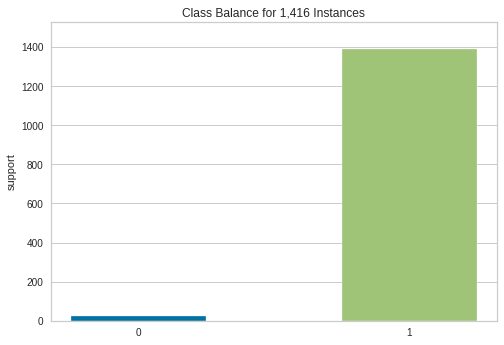

In [75]:
from yellowbrick.target import class_balance
class_balance(Y_train);

In [76]:

# up sample with SMOTE
sm = SMOTE(random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=cpgn)

Y_train_upsamp = pd.Series(Y_train_upsamp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [77]:
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'binary:logistic',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:1	validation_1-auc:1
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:1	validation_1-auc:1
[2]	validation_0-auc:1	validation_1-auc:1
[3]	validation_0-auc:1	validation_1-auc:1
[4]	validation_0-auc:1	validation_1-auc:1
[5]	validation_0-auc:1	validation_1-auc:1
[6]	validation_0-auc:1	validation_1-auc:1
[7]	validation_0-auc:1	validation_1-auc:1
[8]	validation_0-auc:1	validation_1-auc:1
[9]	validation_0-auc:1	validation_1-auc:1
[10]	validation_0-auc:1	validation_1-auc:1
[11]	validation_0-auc:1	validation_1-auc:1
[12]	validation_0-auc:1	validation_1-auc:1
[13]	validation_0-auc:1	validation_1-auc:1
[14]	validation_0-auc:1	validation_1-auc:1
[15]	validation_0-auc:1	validation_1-auc:1
[16]	validation_0-auc:1	validation_1-auc:1
[17]	validation_0-auc:1	validation_1-auc:1
[18]	validation_0-auc:1	validation_1-auc:1
[19]	validation_0-auc:1	validation_1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

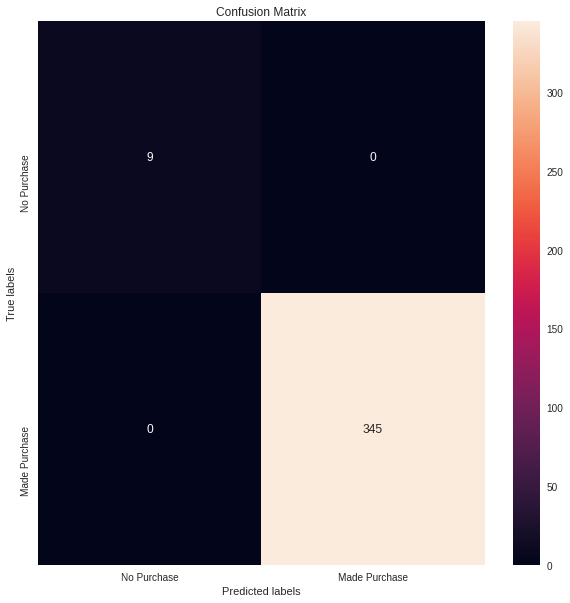

In [78]:

# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [79]:
def promotion_strategy(df):
    '''         
    Ex:
    INPUT: df
    AcceptedCmp1->AcceptedCmp2->AcceptedCmp3->AcceptedCmp4->AcceptedCmp5->Income->Recency->NumWebVisitsMonth
    OUTPUT: promotion
    array([1, 1, 0])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    # Fit a model with treatment = 1 for all data points
    test['treatment'] = 1.0
    preds_treat = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    
    # Fit a model with treatment = 0 for all data points
    test['treatment'] = 0.0
    preds_cont = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    lift = preds_treat[:,1] - preds_cont[:,1]
    
    promotion = []
    for prob in lift:
        if prob > 0:
            promotion.append(1)
        else:
            promotion.append(0)

    promotion = np.array(promotion)
    return promotion

In [80]:
# find out irr and nlr on our validation set
valid_results(promotion_strategy, valid)


Your Revenue generated with this strategy is -518.00.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


-518

In [81]:
test_results(promotion_strategy, test)


Your Revenue generated with this strategy is -422.00.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


-422

# Model 4: Four Quadrants Approach

This model helps to predict an individual's probability of being in any of the 4 groups: TR, CR, TN, CN.

TR: Treatment and Responded. Basically received promotion and made a purchase CR: Control and Responded. Did not receive a promotion but made a purchase TN: Treatment and No Response. Received promotion but made no purchase CN: Control and No Response. Did not receive a promotion and made no purchase.

If an individual's TR probability is the highest among the four groups, it is likely that we will benefit by sending the individual a promotion to induce him or her to make a purchase.In other words, if for an individual:

$$ max[P(TR), P(CR), P(TN), P(CN)] = P(TR)$$
we should send a promotion.

This model has predicted that the company would get the maximum profit through this model. It predicted that the company would generate a profit of $111.

In [82]:
train, test = sk.model_selection.train_test_split(df, test_size=0.2,random_state=42)

In [83]:
target = []
for index, row in train.iterrows():
    if (row['Discount'] == 1) & (row['Response'] == 1):
        # TR group
        target.append(0)
    elif (row['Discount'] == 0) & (row['Response'] == 1):
        # CR group
        target.append(1)
    elif (row['Discount'] == 0) & (row['Response'] == 0):
        # TN group
        target.append(2)
    else: #CN group
        target.append(3)

train['target'] = target
train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Discount,target
1998,5370,32644.0,38,239,3,141,0,7,23,8,1,0,0,0,0,0,0,1,3
814,6303,91820.0,72,410,73,747,76,161,30,1,0,0,0,0,0,0,0,0,2
1513,9264,79529.0,1,423,42,706,73,197,197,2,0,0,0,0,0,0,0,1,3
1381,7514,54342.0,74,84,10,34,11,10,28,6,0,0,0,0,0,0,0,1,3
919,4637,74637.0,73,960,64,464,146,0,16,3,0,0,0,1,0,0,0,1,3


In [84]:
train, valid = sk.model_selection.train_test_split(train, test_size=0.2,random_state=42)

cpgn=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Income','Recency','NumWebVisitsMonth']

Y_train = train['target']
X_train = train[cpgn]

Y_valid = valid['target']
X_valid = valid[cpgn]

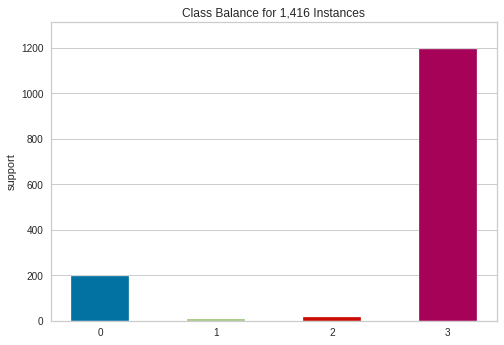

In [85]:
from yellowbrick.target import class_balance
class_balance(Y_train);


In [86]:
# up sample with SMOTE
sm = SMOTE({0:33444, 1:33444, 2:33444, 3:33444}, random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=cpgn)

Y_train_upsamp = pd.Series(Y_train_upsamp)
Y_train_upsamp.value_counts()

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (33444) in class 0 will be larger than the number of samples in the majority class (class #3 -> 1194)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (33444) in class 1 will be larger than the number of samples in the majority class (class #3 -> 1194)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (33444) in class 2 will be larger than the number of samples in the majority class (class #3 -> 1194)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (33444) in class 3 will be larger than the number of samples in the majority class (class #3 -> 1194)
  n

3    33444
2    33444
1    33444
0    33444
dtype: int64

In [87]:
X_train_upsamp.head()

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Income,Recency,NumWebVisitsMonth
0,0.0,0.0,0.0,0.0,0.0,31353.0,24.0,8.0
1,0.0,0.0,0.0,0.0,0.0,43185.0,88.0,8.0
2,0.0,0.0,0.0,0.0,0.0,81657.0,69.0,1.0
3,1.0,0.0,0.0,0.0,0.0,60597.0,2.0,7.0
4,0.0,0.0,0.0,0.0,0.0,78331.0,97.0,4.0


In [88]:

eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          
                                  max_depth = 8,\
                                  min_child_weight = 5,\
                                  objective = 'multi:softmax',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="mlogloss", verbose=True, early_stopping_rounds=30)

[0]	validation_0-mlogloss:1.22995	validation_1-mlogloss:1.27698
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.1026	validation_1-mlogloss:1.18754
[2]	validation_0-mlogloss:0.995083	validation_1-mlogloss:1.11362
[3]	validation_0-mlogloss:0.906031	validation_1-mlogloss:1.05047
[4]	validation_0-mlogloss:0.827493	validation_1-mlogloss:0.9957
[5]	validation_0-mlogloss:0.759863	validation_1-mlogloss:0.946319
[6]	validation_0-mlogloss:0.699486	validation_1-mlogloss:0.904766
[7]	validation_0-mlogloss:0.646691	validation_1-mlogloss:0.867978
[8]	validation_0-mlogloss:0.600277	validation_1-mlogloss:0.8372
[9]	validation_0-mlogloss:0.55915	validation_1-mlogloss:0.806171
[10]	validation_0-mlogloss:0.521166	validation_1-mlogloss:0.781139
[11]	validation_0-mlogloss:0.486957	validation_1-mlogloss:0.757694
[12]	validation_0-mlogloss:0.456413	validation_1-ml

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

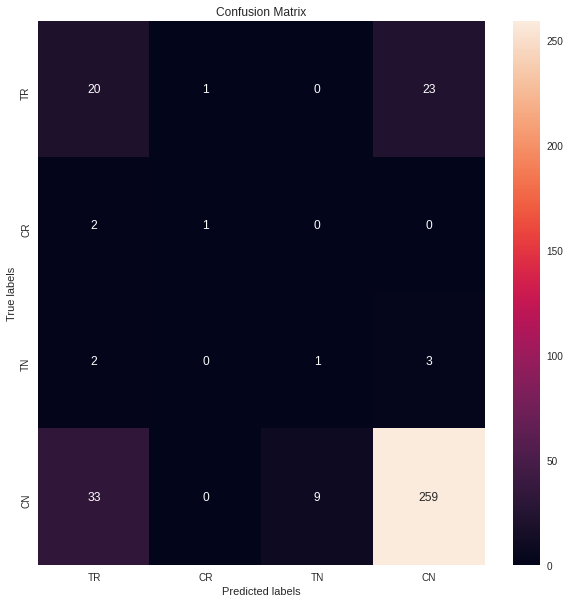

In [89]:

# confusion marix for the validation set
# Note:
# TR: treatment and respond group (received promotion and made purchase)
# CR: control and respond group (did not receive promotion but made purchase)
# TN: treatment and no respond group (received promotion but did not made purchase)
# CR: control and no respond group (did not receive promotion and made no purchase)
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']); 
ax.yaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']);

In [90]:
def promotion_strategy(df):
    '''     
    Ex:
    INPUT: df
    AcceptedCmp1->AcceptedCmp2->AcceptedCmp3->AcceptedCmp4->AcceptedCmp5->Income->Recency->NumWebVisitsMonth
    OUTPUT: promotion
    
    array([1, 1, 0])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    pred = model.predict(test, ntree_limit=model.best_ntree_limit)
    promotion = []
    for pred in pred:
        if pred == 0:
            promotion.append(1)
        else:
            promotion.append(0)
    promotion = np.array(promotion)
    return promotion

In [91]:
# find out irr and nlr on our validation set
valid_results(promotion_strategy, valid)


Your Revenue generated with this strategy is 83.00.



83

In [92]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy, test)


Your Revenue generated with this strategy is 163.00.



163

# Method Using Pylift

In [107]:
! pip install pylift

     |████████████████████████████████| 102kB 4.5MB/s 
  Created wheel for pylift: filename=pylift-0.1.5-cp37-none-any.whl size=26030 sha256=504e84267e2b6aef01cf80b38ec73b69851fe962b2142d763f06a781e8c754b8
  Stored in directory: /root/.cache/pip/wheels/b3/71/23/2587db6f475f0abec88ac2a48dbcf990df7502df94435a8569
Successfully built pylift


In [110]:
from pylift import TransformedOutcome
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [93]:
df.head()

,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Discount
0,5524,58138.0,58,635,88,546,172,88,88,7,0,0,0,0,0,0,1,1
1,2174,46344.0,38,11,1,6,2,1,6,5,0,0,0,0,0,0,0,1
2,4141,71613.0,26,426,49,127,111,21,42,4,0,0,0,0,0,0,0,1
3,6182,26646.0,26,11,4,20,10,3,5,6,0,0,0,0,0,0,0,1
4,5324,58293.0,94,173,43,118,46,27,15,5,0,0,0,0,0,0,0,1


In [184]:
train, test = sk.model_selection.train_test_split(df, test_size=0.001,random_state=42)
train.head()

,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Discount
446,5954,42618.0,92,76,14,74,13,5,10,8,0,0,0,0,0,0,0,1
1284,5043,26997.0,89,7,23,78,133,49,144,7,0,0,0,0,0,0,0,1
1433,274,34853.0,75,9,3,15,2,3,2,6,0,0,0,0,0,0,0,1
826,9499,93404.0,97,1279,15,287,20,0,15,5,0,1,1,0,0,0,0,1
424,6932,93027.0,77,1285,42,716,55,0,21,2,0,0,1,0,0,0,0,0


In [185]:
train.rename(columns={'Discount':'Treatment',
                      'NumWebVisitsMonth':'Outcome'}, inplace=True)

# train.rename(columns={'Discount':'Treatment',
#                       'Response':'Outcome'}, inplace=True)
train.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Outcome,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Treatment
446,5954,42618.0,92,76,14,74,13,5,10,8,0,0,0,0,0,0,0,1
1284,5043,26997.0,89,7,23,78,133,49,144,7,0,0,0,0,0,0,0,1
1433,274,34853.0,75,9,3,15,2,3,2,6,0,0,0,0,0,0,0,1
826,9499,93404.0,97,1279,15,287,20,0,15,5,0,1,1,0,0,0,0,1
424,6932,93027.0,77,1285,42,716,55,0,21,2,0,0,1,0,0,0,0,0


In [186]:
# df_temp_test = df_test
response = []

for index, row in train.iterrows():
    if (row['Outcome'] >= 1) and (row['Treatment']==1):
        response.append(1.0)
    else:
        response.append(0.0)
        
train['response'] = response
train.head()


# response = []
# for index, row in train.iterrows():
#     if (row['Treatment'] == 1) & (row['Outcome'] == 1):
#         # TR group
#         response.append(0)
#     elif (row['Treatment'] == 0) & (row['Outcome'] == 1):
#         # CR group
#         response.append(1)
#     elif (row['Treatment'] == 1) & (row['Outcome'] == 0):
#         # TN group
#         response.append(2)
#     else: #CN group
#         response.append(3)

# train['response'] = response
# train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Outcome,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Treatment,response
446,5954,42618.0,92,76,14,74,13,5,10,8,0,0,0,0,0,0,0,1,1.0
1284,5043,26997.0,89,7,23,78,133,49,144,7,0,0,0,0,0,0,0,1,1.0
1433,274,34853.0,75,9,3,15,2,3,2,6,0,0,0,0,0,0,0,1,1.0
826,9499,93404.0,97,1279,15,287,20,0,15,5,0,1,1,0,0,0,0,1,1.0
424,6932,93027.0,77,1285,42,716,55,0,21,2,0,0,1,0,0,0,0,0,0.0


In [187]:
features=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3',
      'AcceptedCmp4','AcceptedCmp5','Income',
      'Recency']#,'NumWebVisitsMonth'] #, 'Treatment','Outcome']

# generate features and labels
Y_train = train['response']
X_train = train[features]

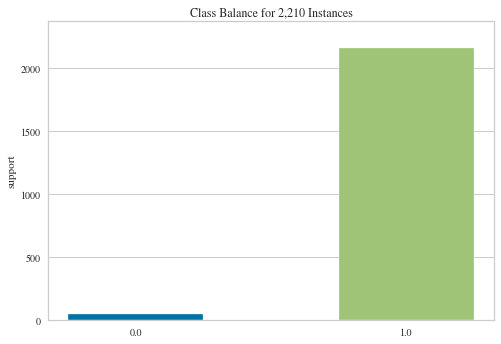

In [188]:
class_balance(Y_train);

In [189]:
# cpgn=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3',
#       'AcceptedCmp4','AcceptedCmp5','Income',
#       'Recency','NumWebVisitsMonth', 'Treatment',
#       'Outcome']
# data_frame_train = train[cpgn]
# data_frame_train.head()
X_train.head()

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Income,Recency
446,0,0,0,0,0,42618.0,92
1284,0,0,0,0,0,26997.0,89
1433,0,0,0,0,0,34853.0,75
826,0,0,0,1,1,93404.0,97
424,0,0,0,0,1,93027.0,77


In [190]:
# cpgn=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Income','Recency','NumWebVisitsMonth']#,'treatment']

# Y_train = train['Discount']
# X_train = train[cpgn]

# Y_valid = valid['Discount']
# X_valid = valid[cpgn]

In [192]:

from imblearn.over_sampling import SMOTENC
# up sample only the train dataset with SMOTE
# sm = SMOTENC(categorical_features=[0,1,2,3,4,7], random_state=42)#, ratio = 1.0)
sm = SMOTENC(categorical_features=[0,1,2,3,4], random_state=42)#, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=list(X_train.columns))
Y_train_upsamp = pd.Series(Y_train_upsamp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


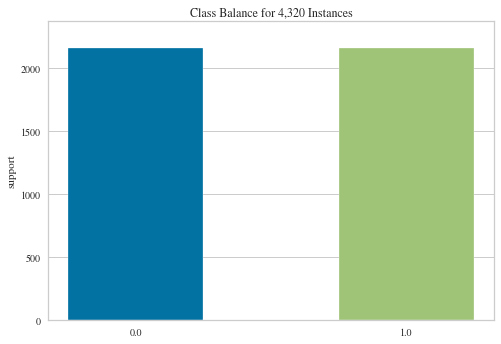

In [193]:
class_balance(Y_train_upsamp);

In [194]:
state = 10

up = TransformedOutcome(data_frame_train,
                         col_treatment='Treatment',
                         col_outcome='Outcome',
                         stratify=data_frame_train['Treatment'],
                         test_size=0.5,
                         continuous_outcome=False,
                         sklearn_model=RandomForestRegressor,
                         random_state=state
                        )

In [195]:
up.randomized_search(param_distributions={
    'n_estimators': [5,10,50,100,1000],
    'max_depth':[2,5,10,20],
    'min_samples_split':[10,100,1000,10000],
    'max_features':['sqrt', 'auto']}, refit=True)
up.fit(**up.rand_search_.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=50, min_samples_split=10, max_features=auto, max_depth=10 
[CV]  n_estimators=50, min_samples_split=10, max_features=auto, max_depth=10, score=-0.386, total=   0.1s
[CV] n_estimators=50, min_samples_split=10, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=10, max_features=auto, max_depth=10, score=0.694, total=   0.1s
[CV] n_estimators=50, min_samples_split=10, max_features=auto, max_depth=10 
[CV]  n_estimators=50, min_samples_split=10, max_features=auto, max_depth=10, score=-0.579, total=   0.1s
[CV] n_estimators=50, min_samples_split=10, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=10, max_features=auto, max_depth=10, score=1.239, total=   0.1s
[CV] n_estimators=50, min_samples_split=10, max_features=auto, max_depth=10 
[CV]  n_estimators=50, min_samples_split=10, max_features=auto, max_depth=10, score=0.657, total=   0.1s
[CV] n_estimators=10, min_samples_split=1000, max_features=sqrt, max_depth=2 
[CV]  n_estimators=10, min_samples_split=1000, max_features=sqrt, max_depth=2, score=-0.147, total=   0.0s
[CV] n_estimators=10, min_samples_split=1000, max_features=sqrt, max_depth=2 
[CV]  n_estimators=10, min_samples_split=1000, max_features=sqrt, max_depth=2, score=-0.205, total=   0.0s
[CV] n_estimators=10, min_samples_split=1000, max_features=sqrt, max_depth=2 
[CV]  n_estimators=10, min_samples_split=1000, max_features=sqrt, max_depth=2, score=0.569, total=   0.0s
[CV] n_estimators=10, min_samples_split=1000, max_features=sqrt, max_depth=2 
[CV]  n_estimators=10, min_samples_split=1000, max_features=sqrt, max_depth=2, sc

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   12.3s finished


In [196]:
up.rand_search_.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_split': 10,
 'n_estimators': 50}

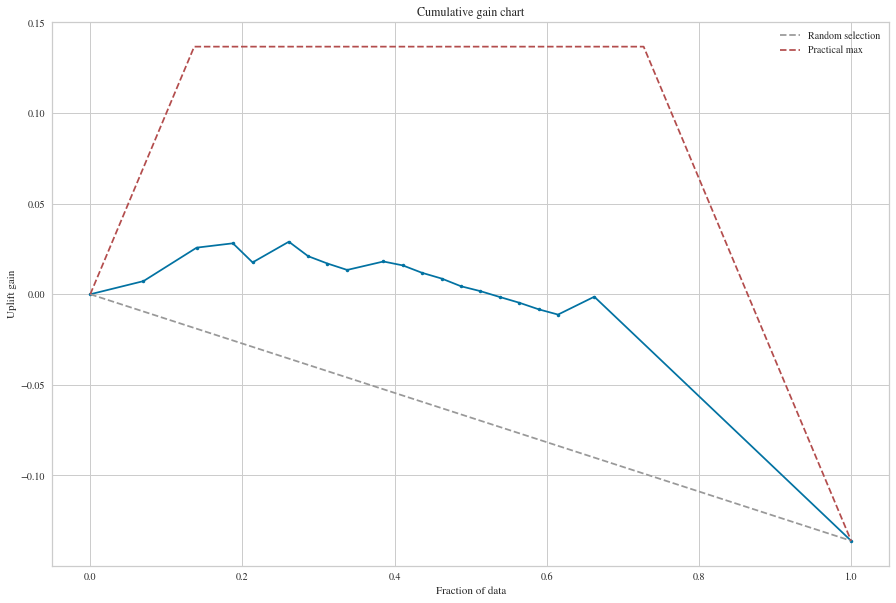

In [197]:
up.plot(plot_type='cgains', show_practical_max=True)

Text(0.5, 1.0, 'Qini Curve (Test)')

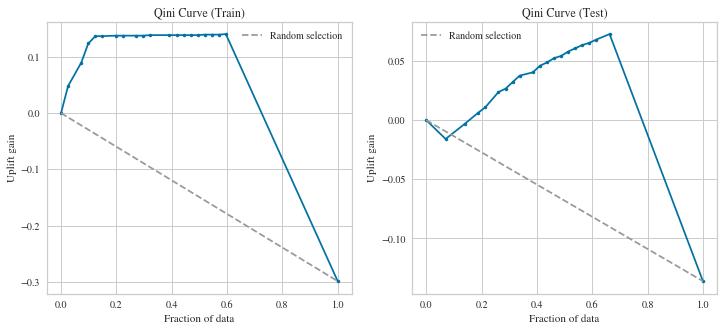

In [198]:
# Plot Train/Test Qini Curve
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
up.train_results_.plot('qini', ax=ax, show_random_selection=True)
ax.set_title("Qini Curve (Train)")
ax = fig.add_subplot(122)
up.test_results_.plot('qini', ax=ax, show_random_selection=True)
ax.set_title("Qini Curve (Test)")

In [199]:
def visit_rate_ate(df, test_set=False):
    treatment_visit_rate = df[df.Treatment == 1].Outcome.mean() * 100
    control_visit_rate = df[df.Treatment == 0].Outcome.mean() * 100
    average_treatment_effect = treatment_visit_rate - control_visit_rate
    print("Test set visit rate uplift: {:.2f}%".format(average_treatment_effect))
    return average_treatment_effect

In [200]:
average_treatment_effect = visit_rate_ate(up.df_test, test_set=True)
print("Qini AUC: {:.5f}".format(up.train_results_.Q_qini))
print("Qini AUC: {:.5f}".format(up.test_results_.Q_qini))

Test set visit rate uplift: -13.61%
Qini AUC: 0.27496
Qini AUC: 0.10726


In [201]:
from sklearn.model_selection import RandomizedSearchCV,  train_test_split, GridSearchCV

response_train_df = up.df_train[up.df_train.Treatment==1].copy()
response_test_df = up.df_test.copy()

response_train_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)
response_test_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)

response_train_label = response_train_df.Outcome
response_test_label = response_test_df.Outcome
response_train_df = response_train_df.drop(columns='Outcome')
response_test_df = response_test_df.drop(columns='Outcome')

gs = GridSearchCV(
    RandomForestClassifier(n_estimators=1000),
    param_grid={'max_depth':[3,5,7,9,11]},
    scoring='accuracy',
    n_jobs=4,
    iid=False,
    cv=5
)
gs.fit(response_train_df, response_train_label)
response_model = RandomForestClassifier(n_estimators=1000, **gs.best_params_)
response_model.fit(response_train_df, response_train_label)
y_pred_response = response_model.predict_proba(response_test_df)[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [202]:
# Test set dataframe containing uplift/response scores scorted into deciles
results_df = up.df_test.copy()
results_df['response'] = y_pred_response
results_df['uplift'] = up.transformed_y_test_pred
results_df['response_decile'] = pd.qcut(y_pred_response, 10)
results_df['uplift_decile'] = pd.qcut(up.transformed_y_test_pred, 10)

results_df.head()

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Income,Recency,NumWebVisitsMonth,Treatment,Outcome,TransformedOutcome,response,uplift,response_decile,uplift_decile
977,0,0,0,0,0,56962.0,60,7,1,0,0,0.072454,0.166068,"(0.0689, 0.0861]","(0.125, 0.202]"
1190,0,0,0,0,0,78579.0,35,3,1,1,1.02031,0.073673,0.009052,"(0.0689, 0.0861]","(0.00149, 0.00939]"
1739,0,0,0,0,0,42403.0,18,8,1,0,0,0.111124,0.047615,"(0.0861, 0.139]","(0.0261, 0.0481]"
742,0,0,0,0,0,48767.0,79,5,1,0,0,0.050840,0.058354,"(0.0475, 0.0518]","(0.0481, 0.0847]"
1556,0,0,1,0,0,47175.0,81,8,1,1,1.02031,0.340844,0.302828,"(0.221, 0.344]","(0.202, 0.373]"


In [203]:
def compute_visit_rates(results_df, for_response=True):
    if for_response:
        targeting_strategy = 'response_decile'
    else:
        targeting_strategy = 'uplift_decile'

    treatment_group = results_df[results_df.Treatment == 1]
    control_group = results_df[results_df.Treatment == 0]

    treatment_visit_rates = (treatment_group.groupby(targeting_strategy)['Outcome'].mean() * 100).reset_index()
    control_visit_rates = (control_group.groupby(targeting_strategy)['Outcome'].mean() * 100).reset_index()

    treatment_visit_rates[targeting_strategy] = treatment_visit_rates[targeting_strategy].astype(str)
    control_visit_rates[targeting_strategy] = control_visit_rates[targeting_strategy].astype(str)

    treatment_visit_rates.columns = [targeting_strategy, 'visit_rate']
    control_visit_rates.columns = [targeting_strategy, 'visit_rate']

    return treatment_visit_rates, control_visit_rates

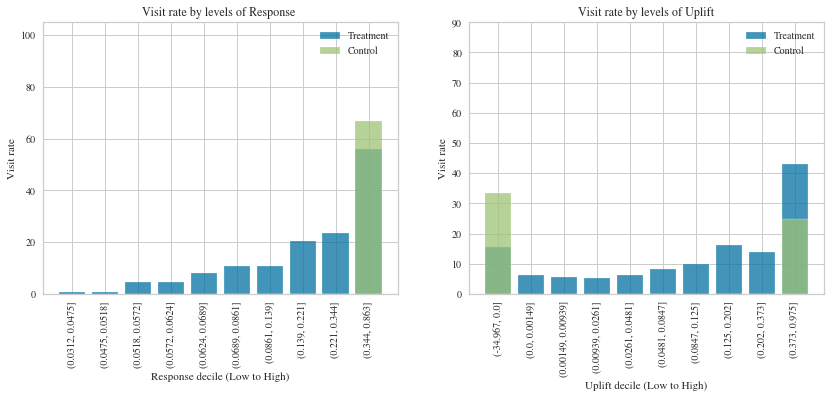

In [204]:
response_visit_rates_t, response_visit_rates_c = compute_visit_rates(results_df, for_response=True)
uplift_visit_rates_t, uplift_visit_rates_c = compute_visit_rates(results_df, for_response=False)

fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.bar(response_visit_rates_t['response_decile'], response_visit_rates_t['visit_rate'], label='Treatment', alpha=0.75)
ax1.bar(response_visit_rates_c['response_decile'], response_visit_rates_c['visit_rate'], label='Control', alpha=0.75)
ax1.set_ylabel("Visit rate")
ax1.set_xlabel("Response decile (Low to High)")
ax1.legend()
ax1.set_title("Visit rate by levels of Response ")
plt.xticks(rotation='vertical')
ax1.set_ylim(0,105)

ax2 = fig.add_subplot(122)
ax2.bar(uplift_visit_rates_t['uplift_decile'], uplift_visit_rates_t['visit_rate'], label='Treatment', alpha=0.75)
ax2.bar(uplift_visit_rates_c['uplift_decile'], uplift_visit_rates_c['visit_rate'], label='Control', alpha=0.75)
ax2.set_ylabel("Visit rate")
ax2.set_xlabel("Uplift decile (Low to High)")
ax2.legend()
ax2.set_title("Visit rate by levels of Uplift")
plt.xticks(rotation='vertical')
ax2.set_ylim(0,90);

del response_visit_rates_t, response_visit_rates_c, uplift_visit_rates_t, uplift_visit_rates_c

In [205]:

def compute_treatment_effect(results_df, for_response=True):
    if for_response:
        targeting_strategy = 'response_decile'
    else:
        targeting_strategy = 'uplift_decile'
    treatment_group = results_df[results_df.Treatment == 1]
    control_group = results_df[results_df.Treatment == 0]

    treatment_visit_rates = (treatment_group.groupby(targeting_strategy)['Outcome'].mean() * 100)
    control_visit_rates = (control_group.groupby(targeting_strategy)['Outcome'].mean() * 100)

    treatment_effect = (treatment_visit_rates - control_visit_rates).reset_index()
    treatment_effect[targeting_strategy] = treatment_effect[targeting_strategy].astype(str)
    treatment_effect.columns = [targeting_strategy, 'treatment_effect']
    return treatment_effect


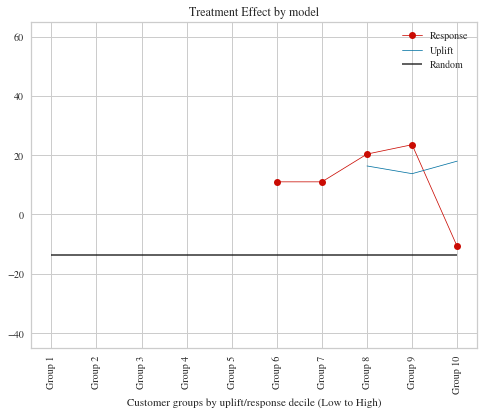

In [206]:
response_treatment_effect = compute_treatment_effect(results_df, for_response=True)
uplift_treatment_effect = compute_treatment_effect(results_df, for_response=False)
response_treatment_effect['group'] = ['Group ' + str(num) for num in range(1,11)]
uplift_treatment_effect['group'] = ['Group ' + str(num) for num in range(1,11)]

plt.figure(figsize=(8,6))
plt.plot(response_treatment_effect['group'], response_treatment_effect['treatment_effect'], 'ro-', linewidth=0.75, label='Response')
plt.plot(uplift_treatment_effect['group'], uplift_treatment_effect['treatment_effect'], 'bx-', linewidth=0.75, label='Uplift')
plt.ylim(-45,65)
plt.xticks(rotation='vertical')
plt.xlabel("Customer groups by uplift/response decile (Low to High)")
plt.title("Treatment Effect by model")
plt.hlines(average_treatment_effect, 0, 9, label='Random', alpha=0.75)
plt.legend();

del response_treatment_effect, uplift_treatment_effect

In [207]:
def _compute_pooled_proportion(p1, n1, p2, n2):
    return ((p1 * n1) + (p2 * n2)) / (n1 + n2)


def _compute_se(p, n1, n2):
    return np.sqrt(p * (1 - p) * ((1 / n1) + (1 / n2)))


def cumulative_treatment_effect(results_df, for_response=True):
    if for_response:
        targeting_strategy = 'response_decile'
    else:
        targeting_strategy = 'uplift_decile'
    treatment_group = results_df[results_df.Treatment == 1]
    control_group = results_df[results_df.Treatment == 0]

    treatment_group_visits = treatment_group.groupby(targeting_strategy)['Outcome'].sum().reset_index()
    treatment_group_visits['total'] = treatment_group.groupby(targeting_strategy)['Outcome'].count().values
    control_group_visits = control_group.groupby(targeting_strategy)['Outcome'].sum().reset_index()
    control_group_visits['total'] = control_group.groupby(targeting_strategy)['Outcome'].count().values

    treatment_group_visits[targeting_strategy] = treatment_group_visits[targeting_strategy].astype(str)
    control_group_visits[targeting_strategy] = control_group_visits[targeting_strategy].astype(str)

    treatment_group_visits.columns = [targeting_strategy, 'num_website_visits', 'total_website_visits']
    control_group_visits.columns = [targeting_strategy, 'num_website_visits', 'total_website_visits']

    # Highest to Lowest decile groups
    treatment_group_visits, control_group_visits = treatment_group_visits.iloc[::-1], control_group_visits.iloc[::-1]

    treatment_group_visits['visits_cumul'] = treatment_group_visits['num_website_visits'].cumsum()
    treatment_group_visits['total_visits_cumul'] = treatment_group_visits['total_website_visits'].cumsum()
    treatment_group_visits['cumul_visit_rate'] = treatment_group_visits['visits_cumul'] / treatment_group_visits[
        'total_visits_cumul']
    control_group_visits['visits_cumul'] = control_group_visits['num_website_visits'].cumsum()
    control_group_visits['total_visits_cumul'] = control_group_visits['total_website_visits'].cumsum()
    control_group_visits['cumul_visit_rate'] = control_group_visits['visits_cumul'] / control_group_visits[
        'total_visits_cumul']

    treatment_effects = treatment_group_visits['cumul_visit_rate'].to_frame().copy().rename(columns={
        'cumul_visit_rate': 'treatment_cumul_visit_rate'})
    treatment_effects['control_cumul_visit_rate'] = control_group_visits['cumul_visit_rate']
    treatment_effects['cumul_treatment_effect'] = (treatment_group_visits['cumul_visit_rate'] - control_group_visits[
        'cumul_visit_rate'])
    p1, p2 = treatment_group_visits['cumul_visit_rate'], control_group_visits['cumul_visit_rate']
    n1, n2 = treatment_group_visits['total_visits_cumul'], control_group_visits['total_visits_cumul']
    treatment_effects['pooled_proportion'] = _compute_pooled_proportion(p1, n1, p2, n2)
    treatment_effects['standard_error'] = _compute_se(treatment_effects['pooled_proportion'].values, n1, n2)

    return treatment_effects.reset_index(drop=True)

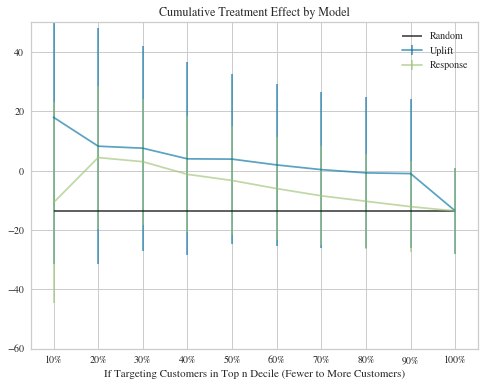

In [208]:
response_cumul_treatment_effect = cumulative_treatment_effect(results_df, for_response=True)
uplift_cumul_treatment_effect = cumulative_treatment_effect(results_df, for_response=False)

response_cumul_treatment_effect['group'] = [str(num*10)+'%' for num in range(1,11)]
uplift_cumul_treatment_effect['group'] = [str(num*10)+'%' for num in range(1,11)]

plt.figure(figsize=(8,6))
plt.errorbar(
    uplift_cumul_treatment_effect['group'], 
    uplift_cumul_treatment_effect['cumul_treatment_effect']*100,
    uplift_cumul_treatment_effect['standard_error']*100*1.96,
    label='Uplift',
    alpha=0.65
)
plt.errorbar(
    response_cumul_treatment_effect['group'], 
    response_cumul_treatment_effect['cumul_treatment_effect']*100,
    response_cumul_treatment_effect['standard_error']*100*1.96,
    label='Response',
    alpha=0.65
)

plt.ylim(-60,50)
plt.xlabel("If Targeting Customers in Top n Decile (Fewer to More Customers)")
plt.hlines(average_treatment_effect, 0, 9, label='Random', alpha=0.75)
plt.xlim(-0.5,9.5)
plt.title("Cumulative Treatment Effect by Model")
plt.legend();

del response_cumul_treatment_effect, uplift_cumul_treatment_effect

In [209]:

results_df['uplift_decile'].value_counts().sort_index(ascending=False).reset_index().\
rename(columns={'uplift_decile': 'number_of_customers', 'index': 'uplift_decile'})

,uplift_decile,number_of_customers
0,"(0.373, 0.975]",111
1,"(0.202, 0.373]",110
2,"(0.125, 0.202]",111
3,"(0.0847, 0.125]",110
4,"(0.0481, 0.0847]",110
5,"(0.0261, 0.0481]",109
6,"(0.00939, 0.0261]",112
7,"(0.00149, 0.00939]",106
8,"(0.0, 0.00149]",31
9,"(-34.967, 0.0]",195


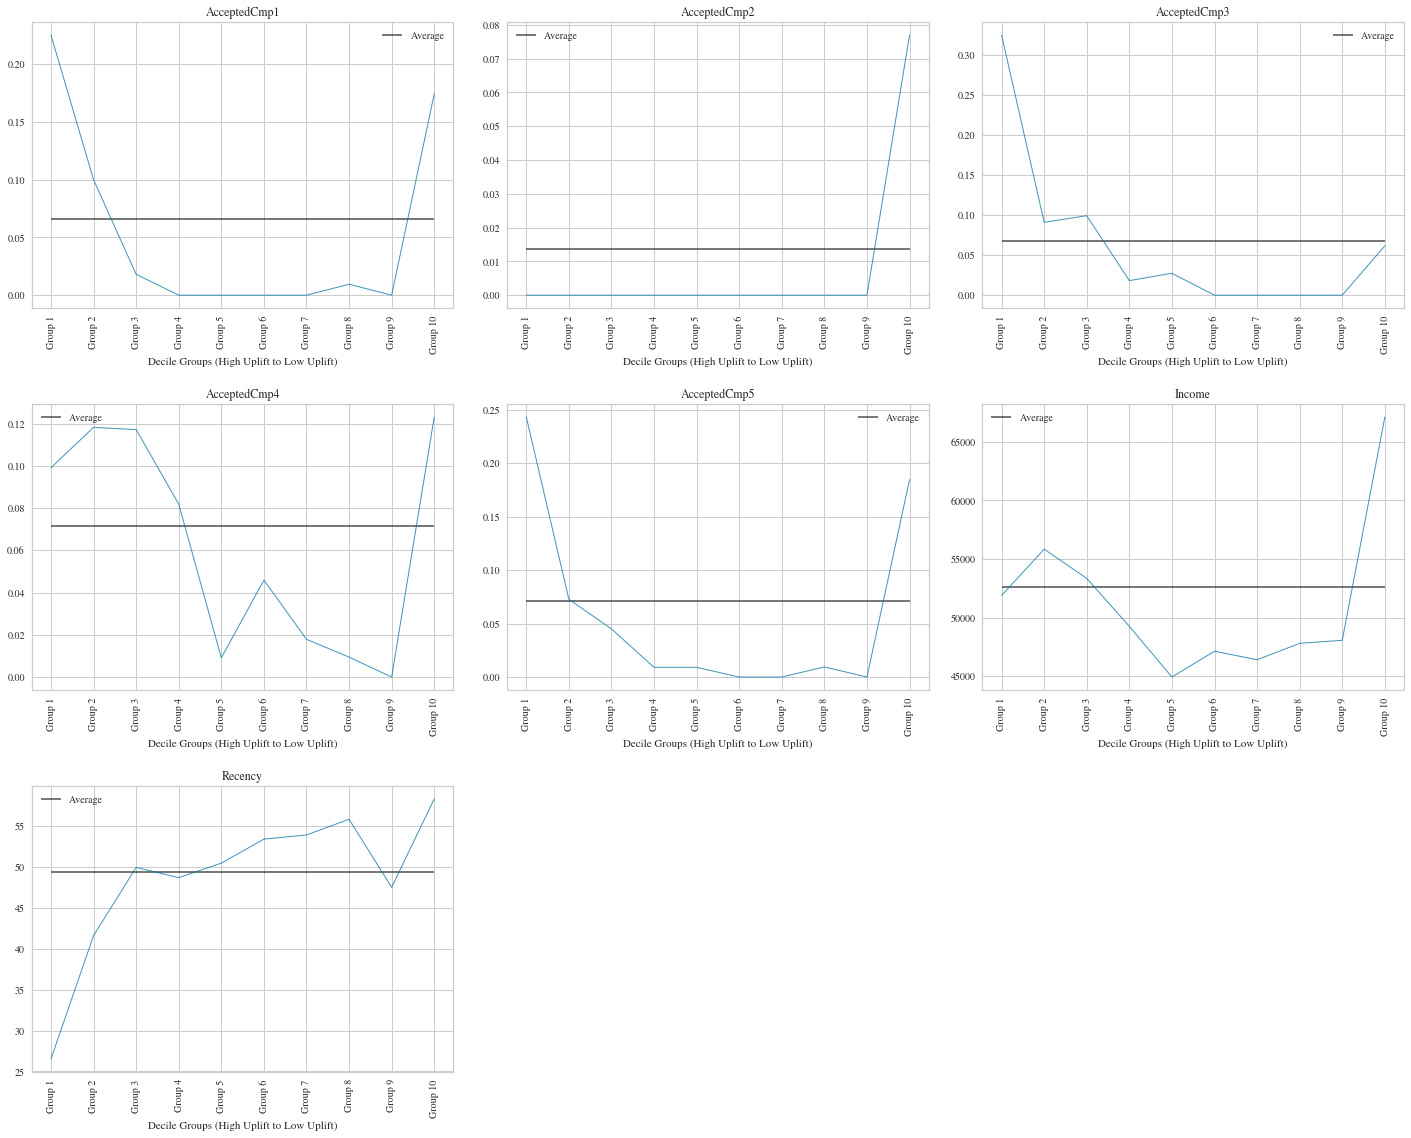

In [210]:
# feats = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
feats = features
avg_feat_per_decile = results_df.groupby("uplift_decile")[feats[0]].mean().sort_index(ascending=False).reset_index()
for feat in feats[1:]:
    avg_feat_per_decile[feat] = results_df.groupby("uplift_decile")[feat].mean().sort_index(ascending=False).values
avg_feat_per_decile['group'] = ['Group ' + str(num) for num in range(1,11)]
avg_feat_per_decile

# print(f"Zip code label encodings: {zip_code_le.classes_}")
# print(f"Channel label encodings: {channel_le.classes_}")

fig = plt.figure(figsize=(20,26))
for idx, feat in enumerate(feats):
    ax = fig.add_subplot(5, 3, idx+1)
    ax.set_xlabel('Decile Groups (High Uplift to Low Uplift)')
    ax.set_title(feat)
    ax.plot(avg_feat_per_decile.group, avg_feat_per_decile[feat], 'bx-', linewidth=1, alpha=0.75)
    plt.xticks(rotation='vertical')
    plt.hlines(results_df[feat].mean(), 0, 9, label='Average', alpha=0.75, linewidth=1.5)
    plt.legend()
plt.tight_layout()